In [1]:
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import PlanesDistCalc as pdc
import LoadStruct as lst
import LigandToResidue as ltr
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from matplotlib.colors import ListedColormap
from collections import defaultdict
plt.style.use('default')
plt.rcParams["font.family"] = "Gulasch", "Times", "Times New Roman", "serif"
res_i_name = 'TYR'
res_j_name = 'ARG'

In [2]:
def xyz_to_pdb(input_filename: str, dir_path: str):
    '''take a xyz file of pairwise converged interaction of truncated amino acids side-chain,
    and transform to a pdb identified ligand in a pdb format using biopython formatting rules.
    The new file gets a 'trj' prefix'''
    if not dir_path.endswith('/'):
        dir_path = dir_path + '/'
    #step A: renumber the identical atoms to distinguish them for later renaming
    ligands_num = 2
    #create the sorted mid step file
    final_input_filename = 'sorted_' + input_filename 
    ltr.create_output(ligands_num, input_filename, dir_path)
    #step B: use the sorted file as a pdb file, and a dictionary of well defined bond lengths to identify the residue
    out_path = dir_path + 'pdbs/'
    out_file = ltr.create_greek_pdb_output(ligands_num, final_input_filename, dir_path, out_path)
    return out_file

def assign_post_opt_params(res_i_name: str,res_j_name: str,final_path: str, file: str, list_confs: list) -> list:
    '''Extract P,D,T1,T2 values from a given pdb file and append to the provided list'''
    pdb_file = final_path + file
    struct = lst.get_pdb_structure(pdb_file)
    chains_dict = lst.create_chain_dict(struct)

    shortest_thresh = 10

    #pairwise post-analysis
    list_pairs = []
    res_arr = []
    for chain_id, chain_obj in chains_dict.items():
        for residue in chain_obj.get_list():
            res_arr.append(residue)
    residue_i = res_arr[0]
    residue_j = res_arr[1]

    if pdc.is_H_bond(residue_i, residue_j):
        print(file)
        is_H_b = True
    else:
        is_H_b = False

    if pdc.is_CH_bond(residue_i, residue_j):
        is_CH_b = True
    else:
        is_CH_b = False

    residue_i_idx = residue_i.get_id()[1]
    residue_j_idx = residue_j.get_id()[1]
    chain_id = 'A'
    title='RES'
    list_pairs = pdc.find_cation_pi_uknown_idx(residue_i, residue_i_idx, residue_j, residue_j_idx, shortest_thresh, pdb_file, chain_id, list_pairs)
    D_val = list_pairs[0]['distance']
    T1_val = list_pairs[0]['Theta1']
    T2_val = list_pairs[0]['Theta2']
    split_filename = file.split('_')
    pdb_name = split_filename[1]
    chain_id = split_filename[2]
    res_i_id = split_filename[3]
    res_j_id = split_filename[4]

    list_confs.append({"pdb_file": pdb_name,
                                    "chain_id": chain_id,
                                    "res_i_id": res_i_id,
                                    "res_j_id": res_j_id,
                                    "D": D_val,
                                    "Ttheta1": T1_val,
                                    "Ttheta2": T2_val,
                                    "H-bond": is_H_b,
                                    "CH_bond": is_CH_b
                                    })

    return list_confs


In [ ]:
dir_path = f'<path_where_all_pairwise_pdbs_are_stored_with_{res_i_name}_{res_j_name}>'
list_confs = []

final_path = f'<path_where_to_store_all_final_pdb_files>'
#analyzed file
for filename in os.listdir(dir_path):
    f = os.path.join(dir_path, filename)
    #check if it is indeed pdb and has not ran before (not a sorted mid-file)
    if not filename.startswith('sort') and filename.endswith('.pdb'):
        #print(filename)
        out_file = xyz_to_pdb(filename, dir_path)
        # calculate parameters for output files (after QM optimization)
        assign_post_opt_params(res_i_name,res_j_name,final_path, out_file, list_confs)

confs_arr = pd.DataFrame(list_confs)
# was already saved before:
confs_arr.to_csv(f'csv_files/{res_i_name}_{res_j_name}_xyz_confs.csv')

In [2]:
def extract_sptial_params(file_name,suffix):
    ''' extract digits from a string according to position'''
    splitted_name = file_name.split('_')
    pdb_file = splitted_name[0]
    chain_id = splitted_name[1]
    res_i_id = splitted_name[2]
    res_i_name = splitted_name[4]
    res_j_name = splitted_name[5]
    res_j_id = splitted_name[3]
    return pdb_file,chain_id,res_i_id,res_i_name,res_j_id,res_j_name

def extract_struct_id(all_confs_df,pdb_file,chain_id,res_i_id,res_j_id):
    '''find conformation satisfying pdb name, chain id, and the two residues and return its location in all confs df'''
    for i in range(all_confs_df['pdb_file'].size):
        #print(all_confs_df['pdb_file'][i], all_confs_df['chain_id'][i], all_confs_df['res_i_id'][i], all_confs_df['res_j_id'][i])
        if all_confs_df['pdb_file'][i] == pdb_file and all_confs_df['chain_id'][i] == chain_id and all_confs_df['res_i_id'][i] == int(res_i_id) and all_confs_df['res_j_id'][i] == int(res_j_id):
            return i
    raise ValueError("missing file")

all_confs_path = f'csv_files/{res_i_name}_{res_j_name}_xyz_confs.csv'
all_confs_df = pd.read_csv(all_confs_path, index_col=0)
D_vals = []
T1_vals = []
T2_vals = []
binding_ener_vals = []
pdb_arr = []
chain_arr = []
res_i_arr = []
res_j_arr = []
is_H_b_arr = []
is_CH_arr = []

names_file = f"txt_files/{res_i_name}_{res_j_name}_ener_non_red.txt"
factor = 627.5 # kcal/mol*Hartree

with open(names_file, 'r') as f:
    first_time = True

    for line in f:
        if not '_' in line:
            break
        splited_line = line.split(' ')
        name = splited_line[0]
        energy = splited_line[1]
        #print(name,energy)

        if name.startswith('ref') and not first_time:
            ref2_ener = energy
            continue
        if name.startswith('ref') and first_time:
            ref1_ener = energy
            first_time = False
            continue

        assert 'ref1_ener' in locals(), "Error: Variable ref1_ener does not exist, check the txt input file first line"
        assert 'ref2_ener' in locals(), "Error: Variable ref2_ener does not exist, check the txt input file second line"

        file_name = name
        pdb_file,chain_id,res_i_id,res_i_name,res_j_id,res_j_name = extract_sptial_params(file_name, '_conv.xyz.pdb')
        pdb_arr.append(pdb_file)
        chain_arr.append(chain_id)
        res_i_arr.append(res_i_id)
        res_j_arr.append(res_j_id)
        index = int(extract_struct_id(all_confs_df,pdb_file,chain_id,res_i_id,res_j_id))
        #print(index)
        D_vals.append(all_confs_df.iloc[index]['D'])
        T1_vals.append(all_confs_df.iloc[index]['Ttheta1'])
        T2_vals.append(all_confs_df.iloc[index]['Ttheta2'])
        current_ener = (float(energy) - float(ref1_ener) - float(ref2_ener))*factor
        binding_ener_vals.append(current_ener)
        is_H_b_arr.append(all_confs_df.iloc[index]['H-bond'])
        is_CH_arr.append(all_confs_df.iloc[index]['CH_bond'])
is_CH_arr = np.array(is_CH_arr)

D_vals = np.array(D_vals)
T1_vals = np.array(T1_vals)
T2_vals = np.array(T2_vals)
binding_ener_vals = np.array(binding_ener_vals)
pdb_arr = np.array(pdb_arr)
chain_arr = np.array(chain_arr)
res_i_arr = np.array(res_i_arr)
res_j_arr = np.array(res_j_arr)
is_H_b_arr = np.array(is_H_b_arr) 
Rx_vals = np.abs(D_vals*np.sin(T1_vals*np.pi/180))

# background info (all pdb data)
clustered_data = pd.read_csv(f'csv_files/{res_i_name}_{res_j_name}_Hb.csv')
clustered_D = clustered_data['distance']
clustered_T1 = clustered_data['Theta1']
clustered_T2 = clustered_data['Theta2']
clustered_H_b = clustered_data['H-bond']
# neutron diffraction data
ND_data = pd.read_csv(f'csv_files/{res_i_name}_{res_j_name}_Hb_ND_non_redundant.csv')
ND_D = ND_data['distance']
ND_T1 = ND_data['Theta1']
ND_T2 = ND_data['Theta2']
ND_H_b = ND_data['H-bond']

datasets = [clustered_D, ND_D]
all_D = pd.concat(datasets)

datasets = [clustered_T1, ND_T1]
all_T1 = pd.concat(datasets)

datasets = [clustered_T2, ND_T2]
all_T2 = pd.concat(datasets)

datasets = [clustered_H_b, ND_H_b]
all_H_b = pd.concat(datasets)

'~~~~ ONLY H-B ~~~~~~~~~~~~~~~~~`'
all_D_Hb = all_D[all_H_b==True]
all_T1_Hb = all_T1[all_H_b==True]
all_T2_Hb = all_T2[all_H_b==True]

'~~~~ EXCLUDING H-B ~~~~~~~~~~~~~~~~~`'
all_D_no_Hb = all_D[all_H_b==False]
all_T1_no_Hb = all_T1[all_H_b==False]
all_T2_no_Hb = all_T2[all_H_b==False]


In [3]:
def plot_x_y_over_counts_Hb(fig, x_all,y_all,x,y,z,E,x_label,y_label,z_label,is_z_dist,ax,legend_loc,is_global_scale):

    heatmap, xedges, yedges = np.histogram2d(x_all, y_all, bins=50)
    E_min = E[is_H_b_arr == False].min()
    E_max = -0.5
    if is_global_scale:
        E_min = -5
    # Plot the heatmap as a contour plot
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    #im1 = ax.contourf(heatmap.T, extent=extent, cmap='magma_r')
    im1 = ax.contourf(heatmap.T, extent=extent, cmap='pink_r')

    # Add a colorbar for the heatmap
    cbar = fig.colorbar(im1,ax=ax)
    cbar.set_label('Counts')

    #4D plot
    marker_sizes = []

    if is_z_dist:
        for p in z:
            marker_sizes.append(p**4/4)

    else:
        for p in z:
            marker_sizes.append(p*3)

    for i in range(len(marker_sizes)):
        if is_H_b_arr[i] == True:
            im = ax.scatter(x[i],y[i],c=E[i], cmap='jet_r', marker='>', vmin=E_min, vmax=E_max, s=marker_sizes[i], alpha=0.5, edgecolors='k')
        if is_CH_arr[i] == True:
            im = ax.scatter(x[i],y[i],c=E[i], cmap='jet_r', marker='s', vmin=E_min, vmax=E_max, s=marker_sizes[i], alpha=0.5, edgecolors='k')
        if Rx_vals[i] < 2.3:
            im = ax.scatter(x[i],y[i],c=E[i], cmap='jet_r', marker='X', vmin=E_min, vmax=E_max, s=marker_sizes[i], alpha=0.5, edgecolors='k')
        if is_H_b_arr[i] == False and is_CH_arr[i] == False and  Rx_vals[i] > 2.3:
            im = ax.scatter(x[i],y[i],c=E[i], cmap='jet_r', marker='o', vmin=E_min, vmax=E_max, s=marker_sizes[i], alpha=0.5, edgecolors='k')

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    if is_z_dist:
        ax.set_xticks(range(0, 91, 10))
        ax.set_xlim(0, 90)
        ax.set_yticks(range(0, 91, 10))
        ax.set_ylim(0, 90)

    else: # x should be Dist others are angles
        ax.set_yticks(range(0, 91, 10))
        ax.set_ylim(0, 90)       
        ax.set_xlim(3.0, 6.0)
    ax.set_title(f'{res_i_name}-{res_j_name} Binding Energies', fontweight='bold')
    #plt.legend()

    cbar = fig.colorbar(im,ax=ax)
    cbar.set_label('Binding Energy [kcal/mol]')

    
    ax.scatter([], [], c='k', alpha=0.3, s=55, marker='X', label='cation-pi')
    ax.scatter([], [], c='k', alpha=0.3, s=55, marker='s', label='CH-pi')

    ax.scatter([], [], c='k', alpha=0.3, s=55, marker='>', label='H-bonds')
    ax.scatter([], [], c='k', alpha=0.3, s=55, marker='o', label='other')

    ax.legend(loc=legend_loc)

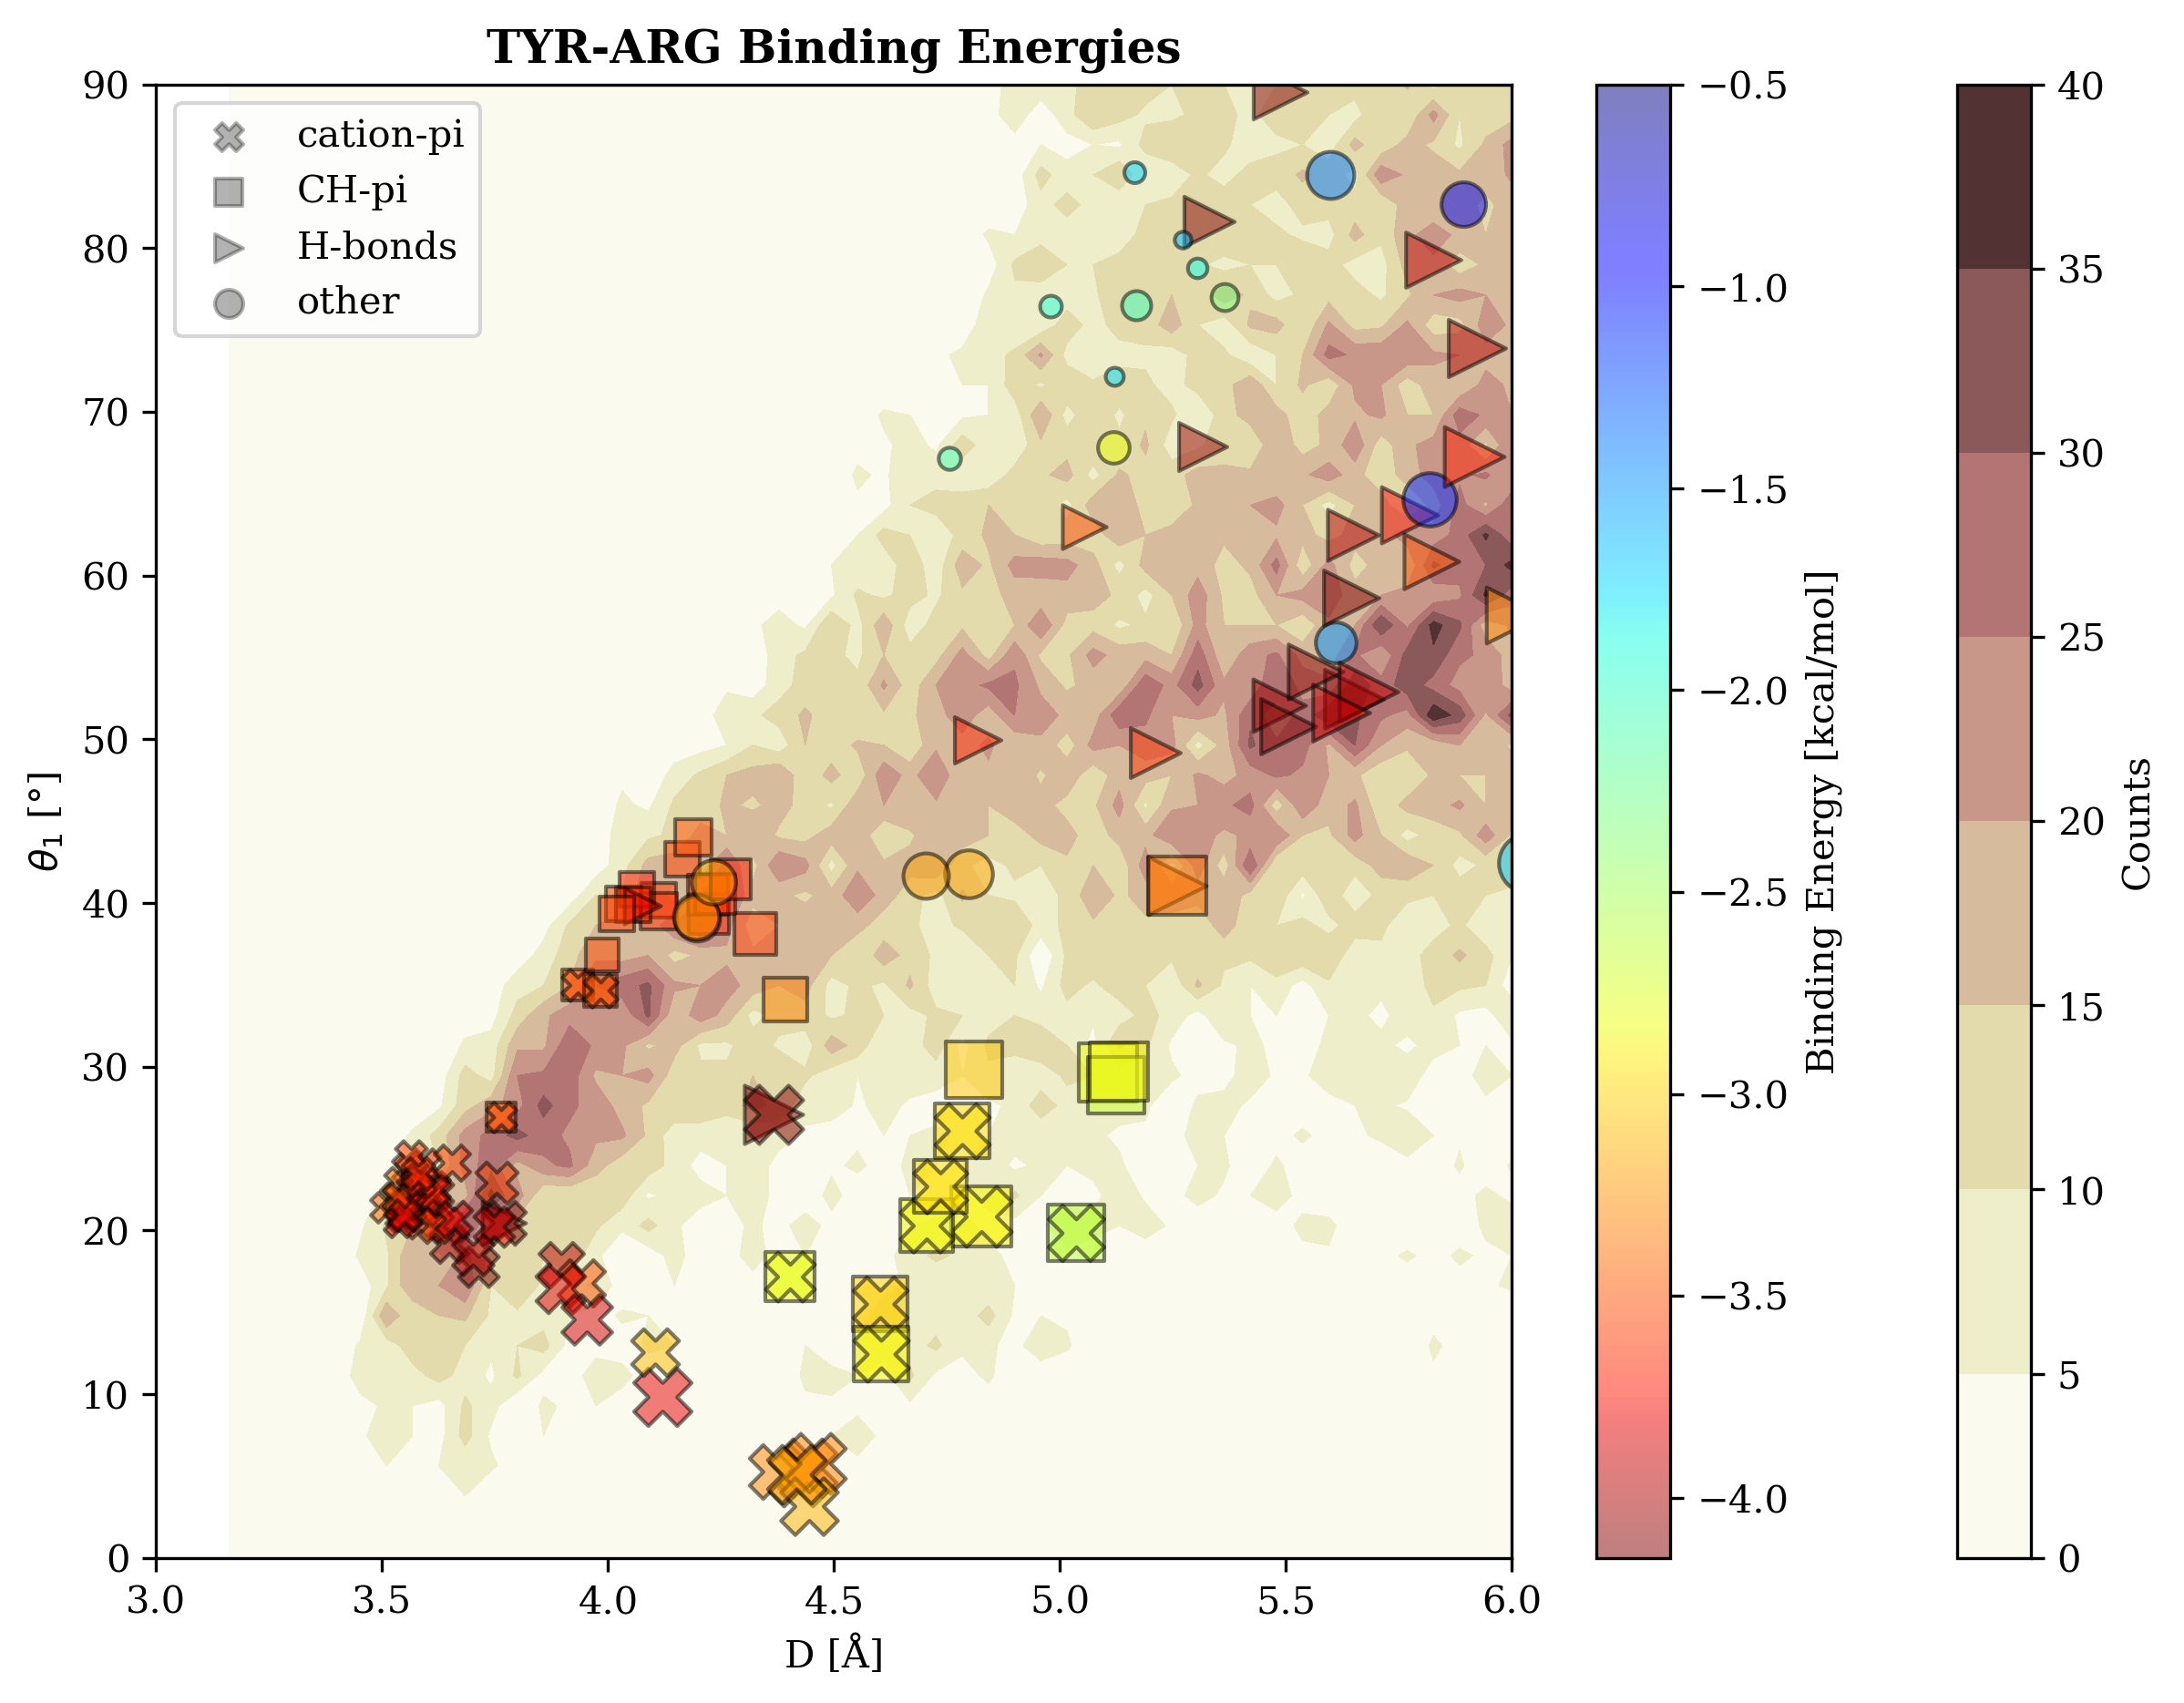

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))
fig.set_dpi(300)

x_all = all_D
y_all = all_T1
x = D_vals
y = T1_vals
z = T2_vals
E = binding_ener_vals

y_label = '$\\theta_1$ [\N{DEGREE SIGN}]'
z_label = '$\\theta_2$ [\N{DEGREE SIGN}]'
x_label = 'D [\N{ANGSTROM SIGN}]'
is_z_dist = False

plot_x_y_over_counts_Hb(fig, x_all, y_all, x, y, z, E, x_label, y_label, z_label, is_z_dist, axes, legend_loc='upper left', is_global_scale=False)
plt.show()